# Recognizing Handwritten Digits


Artificial Intelligence and Deep Learning have today come to an age. Almost every month there is new research in the field sending waves throughout the world.  At the heart of most of these new research you will find convolutional nreural networks, proposed by Yann LeCun et al in their seminal paper [Gradient based learning applied to document recognition](http://yann.lecun.com/exdb/publis/pdf/lecun-98.pdf). In this tutorial we will learn about the classical **LeNet** architecture proposed by Yann LeCun to recognize the handwritten digits. The dataset used for this tutorial is MNIST (Modified National Institute of Standards and Technology) dataset. So get ready for the excited journey into the world's first (almost) commercially successful deep learning application.

###  What you will learn?

* MNIST Dataset and its visualization
* Convolution process
* Pooling process
* Lenet-5 Architecture
* Recognizing handwritten digits using Lenet-5


### Pre-requisite

* Python (along with basics of NumPy, Matplotlib and Keras)
* Understanding of basic matrix manipulations
* Idea of how an artificial neuron or perceptron works


##   Visualizing and Processing MNIST Dataset
 Let us first play around with the dataset. The MNIST Dataset is maintained by Yann Lecun and you can download it directly from his [website](http://yann.lecun.com/exdb/mnist/index.html).  It consists of 60000 labelled images of handwritten digits, and 10000 test images.
 
 When you start learning a programming language you start with "Hello world" program, well MNIST is the *Hello World* of the deep learning, and therefore almost all deep learning libraries have included it into their example datasets.
 
 Let us dive deep into deep learning 😉

###  Downloading MNIST in Keras

Both training and test datasets are directly available in the `keras.dataset` module. To download you just need  to import mnist from it and use `load` function to get training and test data values.

```
from keras.datasets import mnist

(x_train, y_train), (x_test, y_test) = mnist.load_data()

```



In [1]:
from keras.datasets import mnist

(x_train, y_train), (x_test, y_test) = mnist.load_data()


Using TensorFlow backend.


Now x_train, y_train contain test data and its labels and x_test and y_test contain test dataset and its label. Let us examine their length and shape.

In [2]:
print("The number of images in training dataset {}".format(len(x_train)))
print("The shape of training dataset {}".format(x_train.shape))
print("The number of images in test dataset {}".format(len(x_test)))
print("The shape of test dataset {}".format(x_test.shape))

The number of images in training dataset 60000
The shape of training dataset (60000, 28, 28)
The number of images in test dataset 10000
The shape of test dataset (10000, 28, 28)


### Excercise

**Question** How many images are there in the test dataset of MNIST database?

**Answer** 10000

**Hint** Check the length of test dataset.

**Question ** what are the dimensions of individual images?

**Answer** 28x 28

Great!! you guessed right, the last two elements in shape tell us the dimensions of image. Each image consists of 28x28 pixels.


###  Visualizing the handwritten images

The first step in any deep learning project is getting a feel of your data. We also try to see our data and since it consists of 28x28 images, let us plot some images.

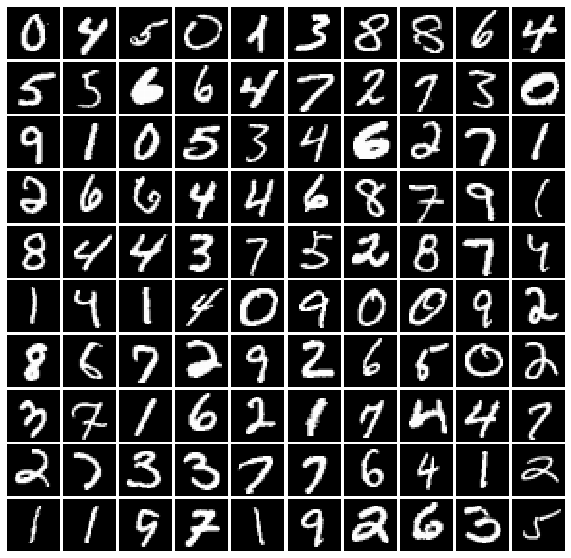

In [3]:
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

import matplotlib.gridspec as gridspec
def plot(samples):
    fig = plt.figure(figsize=(10, 10))
    gs = gridspec.GridSpec(10, 10)
    gs.update(wspace=0.05, hspace=0.05)
    for i, sample in enumerate(samples):
        ax = plt.subplot(gs[i])
        plt.axis('off')
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.set_aspect('equal')
        plt.imshow(sample, cmap='gray')
    return 

import random
idx = np.random.randint(0, len(x_train)-1, 100)
samples = x_train[idx]

plot(samples)


You can see that while some of them are clearly recognizable, for others there is slight confusion. Well worry not you can verify using the labels provided to you, as we do below.

Text(0.5, 1.0, 'Image Label 9')

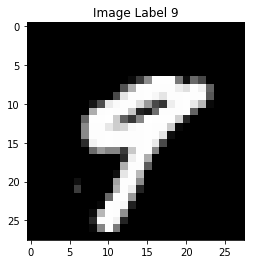

In [4]:
idx = np.random.randint(0, len(x_train)-1)
img = x_train[idx]
plt.imshow(img, cmap = 'gray')
plt.title("Image Label " + str(y_train[idx]))

Play around with this cell get a feel of the dataset and the complexity involved.

### Processing the dataset

If you see the individual images, they are 2D numpy arrays with values lying between 0-255. Well let us write down a neat code to visualize the array values of the image above.

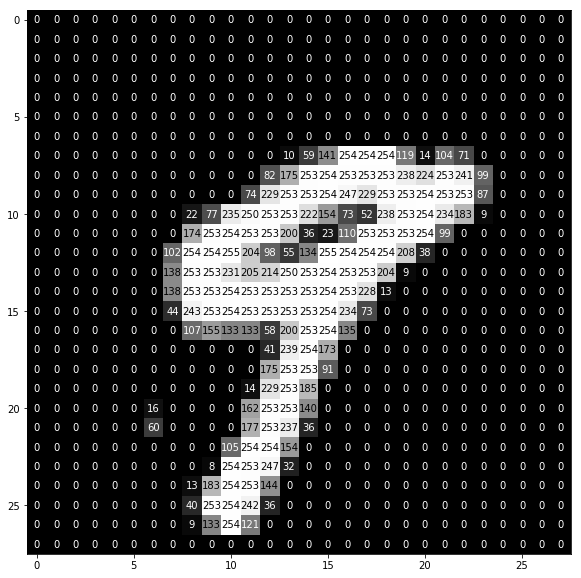

In [5]:
def plot_pixels(img,thresh=2.5):
    fig = plt.figure(figsize = (10,10)) 
    ax = fig.add_subplot(111)
    ax.imshow(img, cmap='gray')
    w, h = img.shape
    threshold = img.max()/thresh
    for x in range(w):
        for y in range(h):
            val = round(img[x][y],1) # if img[x][y] !=0 else 0
            ax.annotate(str(val), xy=(y,x),
                    horizontalalignment='center',
                    verticalalignment='center',
                    color='white' if img[x][y]<threshold else 'black')
    
image = np.squeeze(img)

plot_pixels(image, 2.0)

It is always better to normalize the data, in other words transform it such that it is between 0-1. Why is it so? If you remember how a neuron works, you know that each input is multiplied by weight, and the weighted sum of all the inputs is fed to the neuron. Thus, if you have very large valued inputs, they will contribute most to the sum, resulting in a biased model. Thus large inputs can be detrimental for training and optimization. Moreover, the network trains using back propagation algorithm and large signal values hinder the convergence of the algorithm.


There are many methods we can use to normalize the data. two most commonly used are:

1. **Min-Max normalization** It is one of the most used normalization technique. In this individual data elements are modified using follwing expression:

  $$ x' = \frac {x - x_{min}} {x_{max} - x_{min}} $$

  Here x' is the normalized value, $x_{min}$ and $x_{max}$ are minimum and maximum values of data respectively. 
  
  
2. **Standardization** Here we make use of the mean $\mu$ and standard deviation $\sigma$. The expression being:
  $$ x' = \frac {x - \mu} {\sigma} $$
  
In our example we will use Min Max normalization, and since the images have pixel range 0-255, it reduces to simply scaling individual pixel by $ \frac{1}{255}$

In [6]:
x_train = np.multiply(x_train, 1.0 / 255.0)
x_test = np.multiply(x_test, 1.0 / 255.0)

Now we have normalized data values, let us now visualize the same digit.

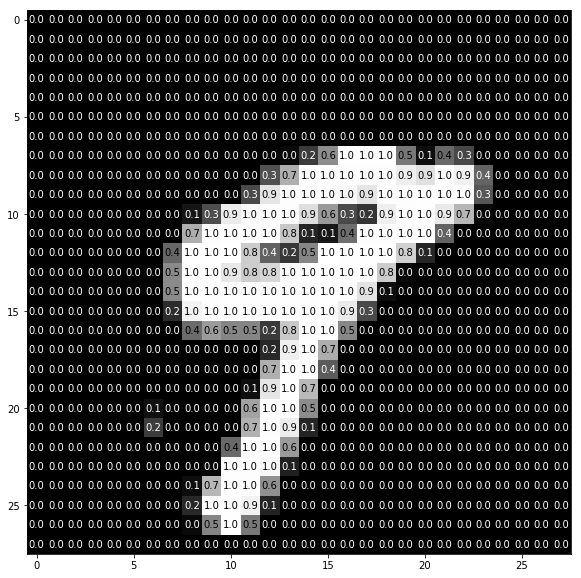

In [7]:
img = x_train[idx]
image = np.squeeze(img)
plot_pixels(image)

Now we have normalized data ready to fed to the model. Well wait a little. We need to also transform the labels.

### What is one hot encoding?

The dataset is labelled in ten classes with `y_train` having values between [0-9]. These labels should be encoded to one hot encoded vector. 

I heard you asking *WHY?*

Well assume we do not hot encode, then we have a single neuron identifying the label of the input image. If its value is 1 (or 0.1 if we normalize) then the input image is label 1. If the output of neuron is 5 (or 0.5) then it corresponds to label 5.

What do you think will be the label if output is 4.5? It can be 4 or 5, not sure, right!

But now instead of 1 neuron, we have 10 neurons corresponding to the 10 labels, each neuron represents the probability of its respective label. Like in the image below, then the label can be simply the neuron with maximum probability. See the image below, what do you think is the label?

![one-hot](image/one-hot.png)
Awesome, you are absolutely right, the input corresponds to label 5 with a probability of 0.7.


If you have a classification task, or categorical data, that is data that can divided into different categories, one hot encoded labels is the best way to go.

The question arises how do we go about it.

### One hot encoding the labels


Now we will need to change the `y_train` and `y_test` such that if the label is 1, the new y has value `0100000000`.

### Excercise

**Question** What would be the hot encoded vector for label 7?

**Answer** 0000000100

We will use `np_utils.to_categorically()` of keras.utils to one hot encode out test and training set data.

In [8]:
from keras.utils import np_utils
print("The shape of output labels before one hot encoding {}".format(y_train.shape))
y_train = np_utils.to_categorical(y_train)
y_test = np_utils.to_categorical(y_test)
print("The shape of output labels after one hot encoding {}".format(y_train.shape))

The shape of output labels before one hot encoding (60000,)
The shape of output labels after one hot encoding (60000, 10)


Did you noticed the change in shape of the labels? Good observation!!  

This ends the first part. Stay tuned for the next part- Convolution Neural Networks.